
This program will take the sorted data directories and generate all of the relevant data matrices

### Need to do:
    - Determine data overlap (what studies we have masks and data for)
    - Prepare training data and testing data for NN
    
### Data ideas:
    Identify slices/regions with tumor:
        - For a slice, 1 or 0 for whether it has a tumor (based off of the masks)
        - For a section of a slice, 1 or 0 for whether it has a tumor (based off the corresponding section of a mask)
        - [Pooling] For a pixel, based on the NxN surrounding pixels on that slide, and on the neighboring (+/- j) slices, use classification of central pixel
    Segmentation:


In [45]:
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import os
import cv2
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import time

In [46]:
types = ['flair','t1','t1Gd','t2',
         'ManuallyCorrected','GlistrBoost']

In [47]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, "Data/")

In [48]:
flair_path = os.path.join(data_dir, 'flair')
flair_files = os.listdir(flair_path)
img = nib.load(os.path.join(flair_path, flair_files[0]))

In [49]:
img_data = img.get_fdata()

In [50]:
test_slice1 = img_data[:, :, 16]
test_slice2 = img_data[:, :, 70]


In [51]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower")

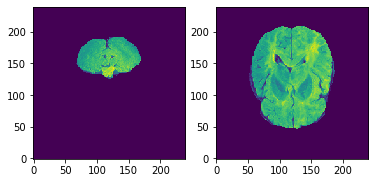

In [52]:
show_slices([test_slice1, test_slice2])

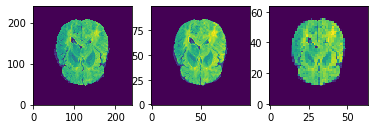

In [53]:
test_slice3 = cv2.resize(test_slice2, dsize=(100,100))
test_slice4 = cv2.resize(test_slice2, dsize=(64,64))
show_slices([test_slice2, test_slice3, test_slice4])

In [63]:
# j_adj_slides = 3 # j, the number of surrounding slices to consider (feature thickness is 2j+1)
Z_local_size = 5 # Z, the dimension of each individual slice segment

def gen_mirror_neighbor(mirr_img, cur_slice_num, x, y):
    """ 
    Returns:
        the feature for a pixel in the input img
    The mirrored image matrix has the buffer on all sides of Z_local_size 
        and on the top and bottom of j_adj_slides
    Therefore the corresponding centerpoint in mirr_img for (x,y,cur_slice_num) is:
    
        [x+Z_local_size, y+Z_local_size, cur_slice_num+j_adj_slides]
    
    And the ZxZx(2j+1) matrix should be:
    
        [(x+Z_local_size)-int(Z_local_size/2):(x+Z_local_size)+int(Z_local_size/2)+1, 
        (y+Z_local_size)-int(Z_local_size/2):(y+Z_local_size)+int(Z_local_size/2)+1,
        cur_slice_num:cur_slice_num+2*j_adj_slides]
    
    where, more clearly:
    
    start_x = (x+Z_local_size)-int(Z_local_size/2)
    end_x = (x+Z_local_size)+int(Z_local_size/2) + 1
    start_y = (y+Z_local_size)-int(Z_local_size/2)
    end_y = (y+Z_local_size)+int(Z_local_size/2) + 1
    start_slide = cur_slice_num
    end_slide = cur_slice_num + 2*j_adj_slides + 1
    
    """    
    feature = mirr_img[
        (x+Z_local_size)-int(Z_local_size/2):(x+Z_local_size)+int(Z_local_size/2)+1, 
        (y+Z_local_size)-int(Z_local_size/2):(y+Z_local_size)+int(Z_local_size/2)+1,
        cur_slice_num
    ]
    
    return feature

def gen_mirror_expansion(img):
    """
    Expand the input img in x and y by mirroring in order to 
    """
#     old_mat = img.get_fdata()
    old_mat = img
    (x_dim, y_dim, slices) = img.shape # Get bounds for img matrix
    new_x_dim = x_dim+2*Z_local_size
    new_y_dim = y_dim+2*Z_local_size
#     new_slices = slices + 2*j_adj_slides
    new_slices = slices # For 2D this is unchanged, since no neighboring slices are included in tensors
    new_img_mat = np.zeros((new_x_dim, new_y_dim, new_slices))
    # Copy in core from original img
    new_img_mat[Z_local_size:x_dim+Z_local_size, Z_local_size:y_dim+Z_local_size, 0:slices] = old_mat
    
    # Mirror boundary in X
    left_edge = np.flip(old_mat[:Z_local_size,:,:], axis=0)
    right_edge = np.flip(old_mat[-Z_local_size:,:,:], axis=0)
    new_img_mat[0:Z_local_size, Z_local_size:y_dim+Z_local_size, 0:slices] = left_edge
    new_img_mat[x_dim+Z_local_size:, Z_local_size:y_dim+Z_local_size, 0:slices] = right_edge
    
    # Mirror Boundary in Y
    top_edge = np.flip(old_mat[:, :Z_local_size, :], axis=1)
    bottom_edge = np.flip(old_mat[:, -Z_local_size:, :], axis=1)
    new_img_mat[Z_local_size:Z_local_size+x_dim, 0:Z_local_size, 0:slices] = top_edge
    new_img_mat[Z_local_size:Z_local_size+x_dim, -Z_local_size:, 0:slices] = bottom_edge
    
    # Mirror Corners
    """Not implemented since corners will likely always be just 0's """

    return new_img_mat
    
def get_neighbor_arrays(img, mask, img_mirror):
    """
    Calls:
        - gen_mirror_neighbor to get feature matrix
        
    Returns:
        - 2 lists
            - One for the data for every pixel classification (list of np arrays)
            - One for the corresponding 3D feature matrix that is ZxZx(2*j+1) for each pixel
    """
    
    (x_dim, y_dim, slices) = img.shape
    
    classifications = []
    features = []
    
    for cur_slice in range(slices):
        for x in range(x_dim):
            for y in range(y_dim):
                feature = gen_mirror_neighbor(img_mirror, cur_slice, x, y)
                if np.sum(feature) == 0:
                    features.append(feature)
                    classifications.append(mask[x,y,cur_slice])
                else:
                    features.append(feature)
                    classifications.append(mask[x,y,cur_slice])
    
    return classifications, features
        

In [55]:
types

['flair', 't1', 't1Gd', 't2', 'ManuallyCorrected', 'GlistrBoost']

In [56]:
flair_data_path = os.path.join(data_dir, 'flair')
t1_data_path = os.path.join(data_dir, 't1')
t1gd_data_path = os.path.join(data_dir, 't1Gd')
t2_data_path = os.path.join(data_dir, 't2')
mask_data_path = os.path.join(data_dir, 'ManuallyCorrected')

flair_files = os.listdir(flair_path)
t1_files = os.listdir(t1_data_path)
t1gd_files = os.listdir(t1gd_data_path)
t2_files = os.listdir(t2_data_path)
mask_files = os.listdir(mask_data_path)



In [57]:
hdd_data_dir = "/Volumes/TumorData/Data"
numpy_dest = os.path.join(hdd_data_dir, "NumpyArraysLSmall2D_Incl_Zeros")

In [58]:
def resize_study(img, new_x, new_y):
    (x_dim, y_dim, slices) = img.shape
#     print ("Input shape: {}".format(img.shape))
    new_dim = (new_x, new_y, slices)
#     print ("New Img shape: {}".format(new_dim))    
    new_img = np.zeros((new_dim))
    for i in range(slices):
        cur_slice = img[:,:,i]
        new_img[:,:,i] = cv2.resize(cur_slice, dsize=(new_x, new_y))
    return new_img

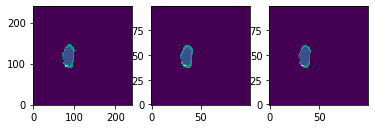

In [59]:
test_mask = nib.load(os.path.join(mask_data_path, 'TCGA-CS-4942.nii')).get_fdata()
test_mask_resample = resize_study(test_mask, 100, 100)

test_mask_slice = test_mask[:,:,70]
test_mask_slice_small = test_mask_resample[:,:,70]
show_slices([test_mask_slice, np.ceil(test_mask_slice_small), test_mask_slice_small.astype(int)])
# It looks like ceiling maintains the definition of boundaries best
# Will binarize for training purposes, since the core of the tumor is less important on a surface model

In [60]:
ceil_max = np.max(np.ceil(test_mask_slice_small))
ceil_min = np.min(np.ceil(test_mask_slice_small))
int_max = np.max(test_mask_slice_small.astype(int))
int_min = np.min(test_mask_slice_small.astype(int))

print ("Ceiling min, max: {}, {}".format(ceil_min, ceil_max))
print ("Astype(int) min, max: {}, {}".format(int_min, int_max))

Ceiling min, max: 0.0, 4.0
Astype(int) min, max: 0, 4


In [64]:
# For each file in a collection, make sure there is a mask, generate the data for that image

new_x = 64
new_y = 64

flair_data = None
flair_classes = None

start_time = time.time()
for i, study in enumerate(flair_files):
    print ("Starting {} out of {} studies.".format(i, len(flair_files)))
    if study in mask_files:
        class_outfile_name = "Flair_Array_"+str(i)+"_Classes"
        features_outfile_name = "Flair_Array_"+str(i)+"_Features"
        class_outfile_path = os.path.join(numpy_dest, class_outfile_name)
        features_outfile_path = os.path.join(numpy_dest, features_outfile_name)
        t = time.time()
        img = nib.load(os.path.join(flair_data_path, study)).get_fdata()
        img = resize_study(img, new_x, new_y) # Resample to be smaller on each slice
        img_mirror = gen_mirror_expansion(img)
        cur_time = time.time()
        elapsed_time = "{:.2f}".format(cur_time-t)
        print ("gen_mirror_expansion took {} seconds".format(elapsed_time))
        t = cur_time
        mask = nib.load(os.path.join(mask_data_path, study)).get_fdata()
        mask = np.where(np.ceil(resize_study(mask, new_x, new_y)).astype(int)>=1, 1, 0)
        classifications, features = get_neighbor_arrays(img, mask, img_mirror)
        cur_time = time.time()
        elapsed_time = "{:.2f}".format(cur_time-t)
        print ("get_neighbor_arrays took {} seconds".format(elapsed_time))
        np.save(class_outfile_path, classifications)
        np.save(features_outfile_path, features)
#         if i == 0:
#             flair_data = np.array(features)
#             flair_classes = np.array(classifications)
#         else:
#             flair_data = np.concatenate((flair_data, features), axis=0)
#             flair_classes = np.concatenate((flair_classes, classifications), axis=0)
end_time = time.time()
print ("Total elapsed time for {} studies: {}".format(len(flair_files), "{:.2f}".format(end_time-start_time)))

Starting 0 out of 65 studies.
gen_mirror_expansion took 0.11 seconds
get_neighbor_arrays took 3.73 seconds
Starting 1 out of 65 studies.
gen_mirror_expansion took 0.14 seconds
get_neighbor_arrays took 3.90 seconds
Starting 2 out of 65 studies.
gen_mirror_expansion took 0.15 seconds
get_neighbor_arrays took 3.94 seconds
Starting 3 out of 65 studies.
gen_mirror_expansion took 0.14 seconds
get_neighbor_arrays took 4.60 seconds
Starting 4 out of 65 studies.
gen_mirror_expansion took 0.10 seconds
get_neighbor_arrays took 3.89 seconds
Starting 5 out of 65 studies.
gen_mirror_expansion took 0.12 seconds
get_neighbor_arrays took 4.46 seconds
Starting 6 out of 65 studies.
gen_mirror_expansion took 0.14 seconds
get_neighbor_arrays took 4.02 seconds
Starting 7 out of 65 studies.
gen_mirror_expansion took 0.14 seconds
get_neighbor_arrays took 3.91 seconds
Starting 8 out of 65 studies.
gen_mirror_expansion took 0.11 seconds
get_neighbor_arrays took 3.93 seconds
Starting 9 out of 65 studies.
gen_mir

In [23]:
data_size = flair_data.shape[0]
data_size

7746003

In [24]:
# flair_training_features = np.zeros((1,5,5,7))
# flair_testing_features = np.zeros((1,5,5,7))

# flair_training_classifications = np.zeros((1))
# flair_testing_classifications = np.zeros((1))

training_size = int(data_size*0.05)
indices = range(data_size)
# flair_train_indices = random.sample(indices, k=training_size)
# flair_test_indices = [i for i in indices if i not in flair_train_indices]

print ("Starting training data array prep")
flair_train_data = flair_data[:training_size]
print ("Starting test data array prep")
flair_test_data = flair_data[training_size:]

print ("Starting prep of classes arrays")

flair_train_classes = flair_classes[:training_size]
flair_test_classes = flair_classes[training_size:]
# print (flair_train_studies)
# print (flair_test_studies)

Starting training data array prep
Starting test data array prep
Starting prep of classes arrays


In [25]:
shapes = [flair_train_data.shape, flair_test_data.shape, flair_train_classes.shape, flair_test_classes.shape]
print (shapes)

[(387300, 3, 3), (7358703, 3, 3), (387300,), (7358703,)]


In [26]:
from sklearn import svm

In [27]:
clf = svm.SVC(verbose=True)

In [28]:
x_train = flair_train_data.reshape(flair_train_data.shape[0], 9)
x_test = flair_test_data.reshape(flair_test_data.shape[0], 9)

In [29]:
x_train.shape

(387300, 9)

In [30]:
clf.fit(x_train, flair_train_classes)

/Users/isaacsmith/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

KeyboardInterrupt: 

In [38]:
'''
  A simple Conv2D example with Keras
'''
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import h5py
import matplotlib.pyplot as plt

In [39]:
# -- Preparatory code --
# Model configuration
batch_size = 1000
no_epochs = 4
learning_rate = 0.001
no_classes = 2
validation_split = 0.2
verbosity = 1
shuffle_buffer_size = 100

In [40]:
# Determine sample shape
sample_shape = flair_train_data.shape
sample_shape = (1000, 5, 5)

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((flair_train_data, flair_train_classes))
test_dataset =  tf.data.Dataset.from_tensor_slices((flair_test_data, flair_test_classes))

train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [42]:
# Create the model
model = Sequential()
model.add(Conv2D(30, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(30, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', data_format='channels_last', input_shape=sample_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

In [43]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])



In [44]:
# Fit data to model

model.fit(train_dataset, validation_data = test_dataset,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity)

Epoch 1/4


ValueError: in user code:

    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/isaacsmith/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 3, 3]
